# I HATE this Product! Five Stars!
##### Reducing Rating Inflation Using NLP
Author: Tom Chapman

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from string import punctuation

import nltk
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag, FreqDist
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import regexp_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.util import ngrams

import pkg_resources

In [3]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /Users/tom/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

## Data Understanding
The data used for training our models is a publicly-available dataset hosted by Kaggle. Users with a Kaggle account and API token already configued can execute the next cell to download the data directly. 

Users without a Kaggle account or that just want to access the data can download it from the [source page](https://www.kaggle.com/datasets/kritanjalijain/amazon-reviews?select=amazon_review_polarity_csv.tgz).

The dataset is a subset of the Stanford Network Analysis Project (SNAP), which contains approximately 34 million Amazon reviews collected over a 13 year period. Our dataset consists of 1.8 million training samples in each polarity (positive or negative) and 200,000 validation samples in each polarity. The subset was created by labelling reviews that assigned a 1-2 star rating to the negative polarity, and reviews with a 4-5 star rating to the positive polarity. Ratings that gave 3 stars were omitted entirely.

Because my goal is to train a classifier that will generalize well across different kinds of products, I chose a dataset that did not specialize in any one category. My hope is that this choice will drive greater accuracy on both Amazon reviews and reviews from other data sources.

In [ ]:
# Users with a Kaggle account & API token can run this cell to download the data directly.
# import kaggle
# kaggle datasets download -d kritanjalijain/amazon-reviews

In [36]:
# Read Train Data
df = pd.read_csv('../data/train.csv', names=['sentiment', 'title', 'text'])                

In [12]:
# XXXX
# Re-read to avoid duplicate cleaning iterations.
# df = pd.read_csv('../data/train_cleaned.csv', index_col=0)

# Data Understanding

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3600000 entries, 0 to 3599999
Data columns (total 5 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   sentiment     int64 
 1   text_cleaned  object
 2   toks          object
 3   bigrams       object
 4   trigrams      object
dtypes: int64(1), object(4)
memory usage: 293.8+ MB


In [28]:
df.head()

,sentiment,text_cleaned,toks,bigrams,trigrams
0,2,sound track beautiful paint senery mind well w...,"['sound', 'track', 'beautiful', 'paint', 'sene...","[('sound', 'track'), ('track', 'beautiful'), (...","[('sound', 'track', 'beautiful'), ('track', 'b..."
1,2,i'm reading lot review say best game soundtrac...,"[""i'm"", 'reading', 'lot', 'review', 'say', 'be...","[(""i'm"", 'reading'), ('reading', 'lot'), ('lot...","[(""i'm"", 'reading', 'lot'), ('reading', 'lot',..."
2,2,soundtrack favorite music time hand intense sa...,"['soundtrack', 'favorite', 'music', 'time', 'h...","[('soundtrack', 'favorite'), ('favorite', 'mus...","[('soundtrack', 'favorite', 'music'), ('favori..."
3,2,truly like soundtrack enjoy video game music p...,"['truly', 'like', 'soundtrack', 'enjoy', 'vide...","[('truly', 'like'), ('like', 'soundtrack'), ('...","[('truly', 'like', 'soundtrack'), ('like', 'so..."
4,2,played game know divine music every single son...,"['played', 'game', 'know', 'divine', 'music', ...","[('played', 'game'), ('game', 'know'), ('know'...","[('played', 'game', 'know'), ('game', 'know', ..."


In [29]:
# Check for NaNs - Unimportant because we will not use the title column.
df.isna().sum()

sentiment        0
text_cleaned    19
toks             0
bigrams          0
trigrams         0
dtype: int64

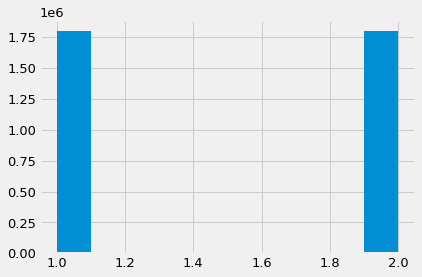

In [40]:
# Visualize sentiment frequency within the dataset
plt.hist(df['sentiment']);

As expected, the data is near-perfectly distributed between the two sentiment classes.

# Data Preprocessing

Preprocessing is a critical piece of any NLP project. Given the large size of the dataset, I created several helper functions to facilitate efficient text cleaning. They appear in order below


## Helper Functions

In [6]:
# POS-Tag Translator

def get_wordnet_pos(treebank_tag):
    '''
    Translate nltk part of speech tags to wordnet tags that can be used by the lemmatizer.
    '''
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [6]:
# Text Cleaner Function

def prepare_text(text, sw=stop_list, regex_pattern = "([a-zA-Z]+(?:'[a-z]+)?)"):
    """
    Tokenize, standardize case, remove punctuation, perform part of speech tagging
    and lemmatize text from string.
    
    Tokenization is performed using a regular expression that grabs words that begin with
    a capital or lowercase letter and end with a lowercase letter.
    """
    # Identify regular expression that will be used to tokenize text
    # regex_pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
    
    # Tokenize words based on the regular expression stored in regex_pattern
    tokenizer = RegexpTokenizer(regex_pattern)
    tokens = tokenizer.tokenize(text)
    
    # Convert tokens to lowercase and remove words in the stop_list variable
    tokens = [token.lower() for token in tokens if token.lower() not in sw]
    
    # Perform part of speech tagging
    tokens_tagged = pos_tag(tokens)
    tokens_tagged = [(word[0], get_wordnet_pos(word[1])) for word in tokens_tagged]
    
    # Perform lemmatization 
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word[0], word[1]) for word in tokens_tagged]
    
    # Return a string consisting of all tokens
    return ' '.join(tokens)

In [8]:
# Function to convert lemmatized text into n-grams.
def trigram_creator(text, n=3):
    return list(ngrams(text.split(), n))

def bigram_creator(text, n=2):
    return list(ngrams(text.split(), n))

In [10]:
# Visualization Function to plot the n most common words in a frequency distribution object

def visualize_top_n(freq_dist, title, n=10):
    """
    Create a dictionary of the n most common words in a frequency distribution and plot a bar
    graph illustrating how many times those words appear in the frequency distribution object.
    """
    plt.style.use('fivethirtyeight')
    plt.rcParams.update({'font.size': 13})
        
    # Extract data for plotting
    top_n = list(zip(*freq_dist.most_common(n)))
    tokens = top_n[0]
    counts = top_n[1]

    # Set up plot and plot data
    fig, ax = plt.subplots(figsize=(10,10))
    ax.bar(tokens, counts)

    # Customize plot appearance
    ax.set_title(title)
    ax.set_ylabel("Count")
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.tick_params(axis="x", rotation=90)
    plt.tight_layout()
    
    # Save png of image to images folder using title as filename
    # plt.savefig(f'./images/{title}', facecolor='white', dpi=500)

In [11]:
# Function to identify common words in positive, negative reviews.

def sw_finder(fd1, fd2, n=10):
    """
    Intake two frequency distribution objects of length n and return a list of the words
    that appear in both objects.
    """
    return list(dict(fd1.most_common(n)).keys() & dict(fd2.most_common(n)).keys())

## Data Cleaning

In [5]:
# Define stopwords
stop_list = stopwords.words("english") 

In [7]:
# Test cleaner function on one row
sample_row = prepare_text(df['text'][0])
print(sample_row)

# Print original text for inspection
df['text'][0]

NameError: name 'df' is not defined

In [14]:
# Apply helper function to 'text' column and store the output in a new column
#df['text_cleaned'] = df['text'].apply(prepare_text)

# Store list of tokens in new column for visual exploration
#df['toks'] = df['text_cleaned'].str.split()

# Create & store bi-grams in a new column
#df['bigrams'] = df['text_cleaned'].apply(bigram_creator)

# Create & store trigrams in a new column
#df['trigrams'] = df['text_cleaned'].apply(trigram_creator)


In [15]:
# Create new dataframe with cleaned text and sentiment, save to csv.
#df.to_csv('../data/train_cleaned.csv', columns=['sentiment', 'text', 'text_cleaned', 'toks', 'bigrams', 'trigrams'])

In [23]:
df.head()

,sentiment,text_cleaned,toks,bigrams,trigrams
0,2,sound track beautiful paint senery mind well w...,"['sound', 'track', 'beautiful', 'paint', 'sene...","[('sound', 'track'), ('track', 'beautiful'), (...","[('sound', 'track', 'beautiful'), ('track', 'b..."
1,2,i'm reading lot review say best game soundtrac...,"[""i'm"", 'reading', 'lot', 'review', 'say', 'be...","[(""i'm"", 'reading'), ('reading', 'lot'), ('lot...","[(""i'm"", 'reading', 'lot'), ('reading', 'lot',..."
2,2,soundtrack favorite music time hand intense sa...,"['soundtrack', 'favorite', 'music', 'time', 'h...","[('soundtrack', 'favorite'), ('favorite', 'mus...","[('soundtrack', 'favorite', 'music'), ('favori..."
3,2,truly like soundtrack enjoy video game music p...,"['truly', 'like', 'soundtrack', 'enjoy', 'vide...","[('truly', 'like'), ('like', 'soundtrack'), ('...","[('truly', 'like', 'soundtrack'), ('like', 'so..."
4,2,played game know divine music every single son...,"['played', 'game', 'know', 'divine', 'music', ...","[('played', 'game'), ('game', 'know'), ('know'...","[('played', 'game', 'know'), ('game', 'know', ..."


In [ ]:
# Ten Most common words in the full dataset
sample_freq_dist = FreqDist(df["text_cleaned"].str.split().explode())
visualize_top_20(sample_freq_dist, "Most Common Words in All Reviews")

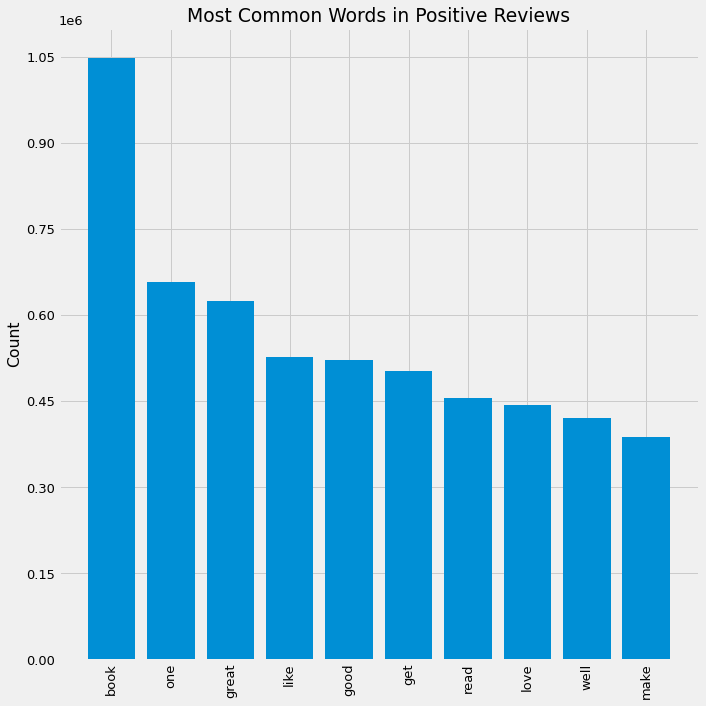

In [15]:
# Ten most common words appearing in positive reviews
pos_freq_dist = FreqDist(df['text_cleaned'].str.split().explode().loc[df['sentiment'] == 2])
visualize_top_n(pos_freq_dist, 'Most Common Words in Positive Reviews', 10)

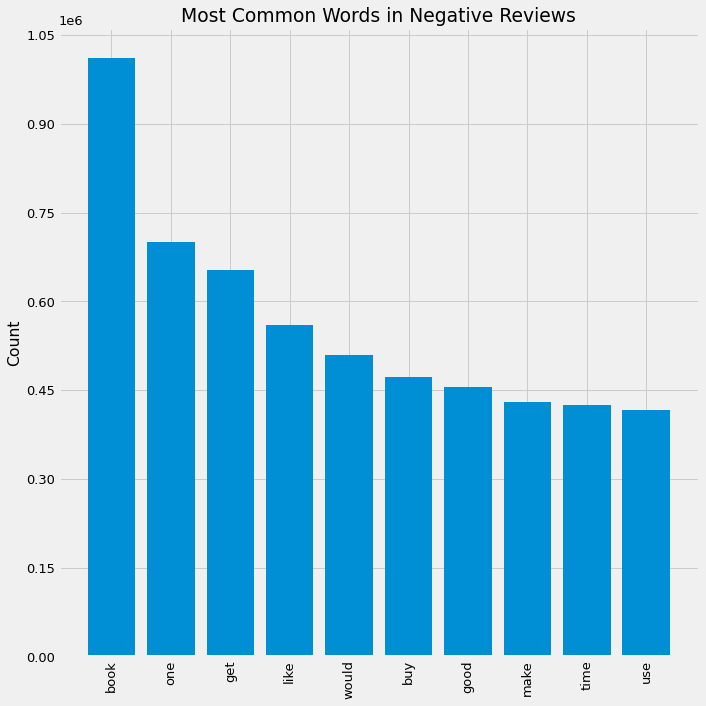

In [16]:
# Ten most common words appearing in negative reviews
neg_freq_dist = FreqDist(df['text_cleaned'].str.split().explode().loc[df['sentiment'] == 1])
visualize_top_n(neg_freq_dist, 'Most Common Words in Negative Reviews', 10)

In [17]:
# Display the first five rows for visual inspection
df.head()

,sentiment,text_cleaned,toks,bigrams,trigrams
0,2,sound track beautiful paint senery mind well w...,"['sound', 'track', 'beautiful', 'paint', 'sene...","[('sound', 'track'), ('track', 'beautiful'), (...","[('sound', 'track', 'beautiful'), ('track', 'b..."
1,2,i'm reading lot review say best game soundtrac...,"[""i'm"", 'reading', 'lot', 'review', 'say', 'be...","[(""i'm"", 'reading'), ('reading', 'lot'), ('lot...","[(""i'm"", 'reading', 'lot'), ('reading', 'lot',..."
2,2,soundtrack favorite music time hand intense sa...,"['soundtrack', 'favorite', 'music', 'time', 'h...","[('soundtrack', 'favorite'), ('favorite', 'mus...","[('soundtrack', 'favorite', 'music'), ('favori..."
3,2,truly like soundtrack enjoy video game music p...,"['truly', 'like', 'soundtrack', 'enjoy', 'vide...","[('truly', 'like'), ('like', 'soundtrack'), ('...","[('truly', 'like', 'soundtrack'), ('like', 'so..."
4,2,played game know divine music every single son...,"['played', 'game', 'know', 'divine', 'music', ...","[('played', 'game'), ('game', 'know'), ('know'...","[('played', 'game', 'know'), ('game', 'know', ..."


### Custom Stopwords

In [18]:
# Identify common words among the 10 most frequent words in reviews of each sentiment
train_sw = sw_finder(neg_freq_dist, pos_freq_dist, 10)
train_sw

['make', 'book', 'good', 'like', 'get', 'one']

In [49]:
# Extend stop_list to include the elements of custom_sw
stop_list.extend(train_sw)

In [50]:
stop_list

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [51]:
# Apply helper function to 'text' column and store the output in a new column
#df['text_cleaned'] = df['text'].apply(prepare_text)

# Store list of tokens in new column for visual exploration
#df['toks'] = df['text_cleaned'].str.split()

# Create & store bi-grams in a new column
#df['bigrams'] = df['text_cleaned'].apply(bigram_creator)

# Create & store trigrams in a new column
#df['trigrams'] = df['text_cleaned'].apply(trigram_creator)

In [52]:
# Create new dataframe with cleaned text and sentiment, save to csv.
#df.to_csv('../data/train_cleaned_10sw.csv', columns=['sentiment', 'text', 'text_cleaned', 'toks', 'bigrams', 'trigrams'])

## Transform Test Data

In [34]:
# Read in valdiation data
df_test = pd.read_csv('../data/test.csv', names=['sentiment', 'title', 'text']) 

In [35]:
df_test.head()

,sentiment,title,text
0,2,Great CD,My lovely Pat has one of the GREAT voices of h...
1,2,One of the best game music soundtracks - for a...,Despite the fact that I have only played a sma...
2,1,Batteries died within a year ...,I bought this charger in Jul 2003 and it worke...
3,2,"works fine, but Maha Energy is better",Check out Maha Energy's website. Their Powerex...
4,2,Great for the non-audiophile,Reviewed quite a bit of the combo players and ...


In [36]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400000 entries, 0 to 399999
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   sentiment  400000 non-null  int64 
 1   title      399990 non-null  object
 2   text       400000 non-null  object
dtypes: int64(1), object(2)
memory usage: 9.2+ MB


In [37]:
# Check for NaNs - Unimportant because we will not use the title column.
df_test.isna().sum()

sentiment     0
title        10
text          0
dtype: int64

In [38]:
# Apply cleaning function to the validation set
df_test['text_cleaned'] = df_test['text'].apply(prepare_text)

# Create & store trigrams in a new column
df_test['bigrams'] = df_test['text_cleaned'].apply(bigram_creator)

# Create & store trigrams in a new column
df_test['trigrams'] = df_test['text_cleaned'].apply(trigram_creator)

In [39]:
df_test.head()

,sentiment,title,text,text_cleaned,bigrams,trigrams
0,2,Great CD,My lovely Pat has one of the GREAT voices of h...,lovely pat one great voice generation listen c...,"[(lovely, pat), (pat, one), (one, great), (gre...","[(lovely, pat, one), (pat, one, great), (one, ..."
1,2,One of the best game music soundtracks - for a...,Despite the fact that I have only played a sma...,despite fact play small portion game music hea...,"[(despite, fact), (fact, play), (play, small),...","[(despite, fact, play), (fact, play, small), (..."
2,1,Batteries died within a year ...,I bought this charger in Jul 2003 and it worke...,bought charger jul work ok design nice conveni...,"[(bought, charger), (charger, jul), (jul, work...","[(bought, charger, jul), (charger, jul, work),..."
3,2,"works fine, but Maha Energy is better",Check out Maha Energy's website. Their Powerex...,check maha energy's website powerex mh c f cha...,"[(check, maha), (maha, energy's), (energy's, w...","[(check, maha, energy's), (maha, energy's, web..."
4,2,Great for the non-audiophile,Reviewed quite a bit of the combo players and ...,review quite bit combo player hesitant due unf...,"[(review, quite), (quite, bit), (bit, combo), ...","[(review, quite, bit), (quite, bit, combo), (b..."


In [40]:
# Save validation data to a new CSV file
df_test.to_csv('../data/test_cleaned.csv', columns=['sentiment', 'text', 'text_cleaned', 'bigrams', 'trigrams'])

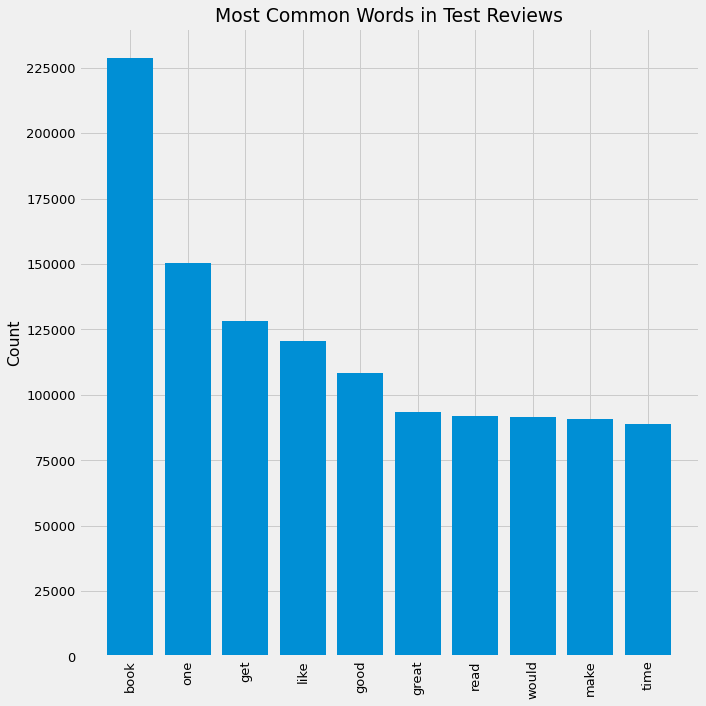

In [42]:
# Ten Most common words in the test dataset
test_freq_dist = FreqDist(df_test["text_cleaned"].str.split().explode())
visualize_top_n(test_freq_dist, "Most Common Words in Test Reviews")

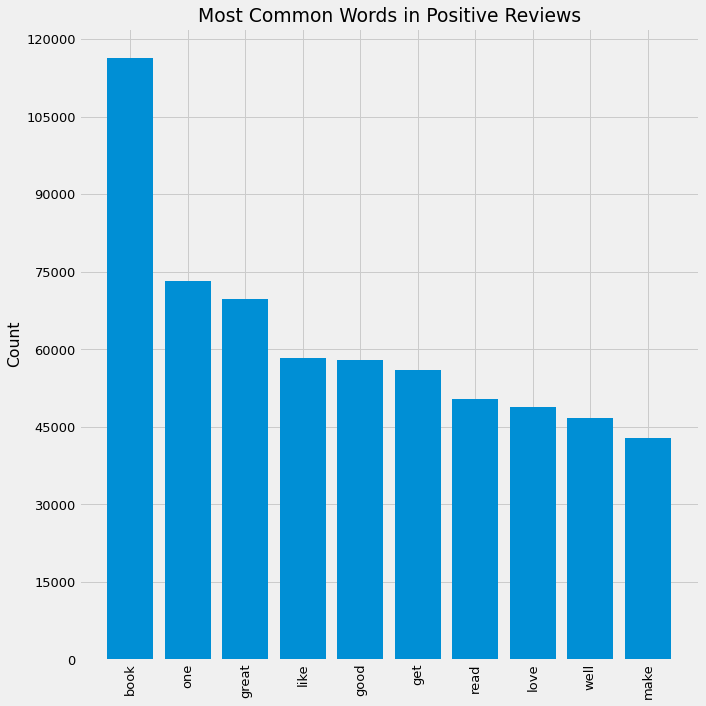

In [43]:
# Ten most common words appearing in positive test reviews
pos_test_dist = FreqDist(df_test['text_cleaned'].str.split().explode().loc[df_test['sentiment'] == 2])
visualize_top_n(pos_test_dist, 'Most Common Words in Positive Reviews', 10)

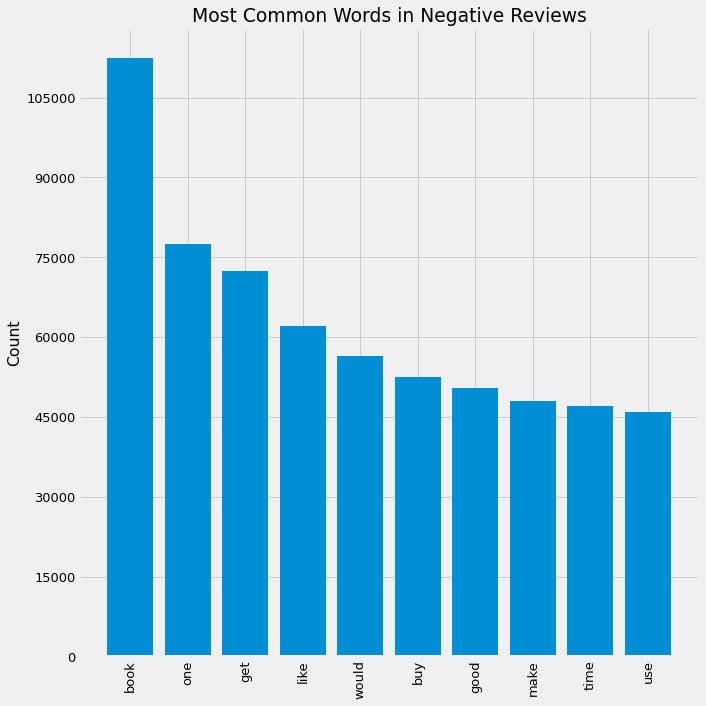

In [44]:
# Ten most common words appearing in negative reviews
neg_test_dist = FreqDist(df_test['text_cleaned'].str.split().explode().loc[df_test['sentiment'] == 1])
visualize_top_n(neg_test_dist, 'Most Common Words in Negative Reviews', 10)

In [45]:
# Identify common words among the 10 most frequent words in reviews of each sentiment
test_sw = sw_finder(neg_test_dist, pos_test_dist, 10)
test_sw

['make', 'book', 'good', 'like', 'get', 'one']

In [46]:
# Re-instantiate stopwords list and extend it to include custom stop words from test data.
stop_list = stopwords.words("english") 
stop_list.extend(test_sw)

In [49]:
# Re-apply cleaning function to 'text' column using identified stopwords 
df_test['text_cleaned'] = df_test['text'].apply(prepare_text)

# Create & store bi-grams in a new column
df_test['bigrams'] = df_test['text_cleaned'].apply(bigram_creator)

# Create & store trigrams in a new column
df_test['trigrams'] = df_test['text_cleaned'].apply(trigram_creator)

In [51]:
# Create new dataframe with cleaned text inclusive of custom sw and sentiment, save to csv.
# df_test.to_csv('../data/test_cleaned_10sw.csv', columns=['sentiment', 'text', 'text_cleaned', 'bigrams', 'trigrams'])